In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load dataset (update path if needed)
df = pd.read_excel("Online Retail.xlsx")

# Display first 5 rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# **Handle Missing Values**
Let’s check for missing values and handle them:

In [27]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing Customer ID
df = df.dropna(subset=['CustomerID'])

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


# **Remove Duplicates**
To ensure clean data, we remove duplicates.

In [28]:
df = df.drop_duplicates()

# **Filter Invalid Transactions**
Since Quantity and Price should be positive, we remove negative values.

In [29]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# **Create a ‘TotalPrice’ Column**
We’ll create a new feature for the total spending per transaction.

In [30]:
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']

# **Check Data Distribution**
Let’s plot **Total Price, Quantity,** and **Unit Price** distributions to detect outliers.

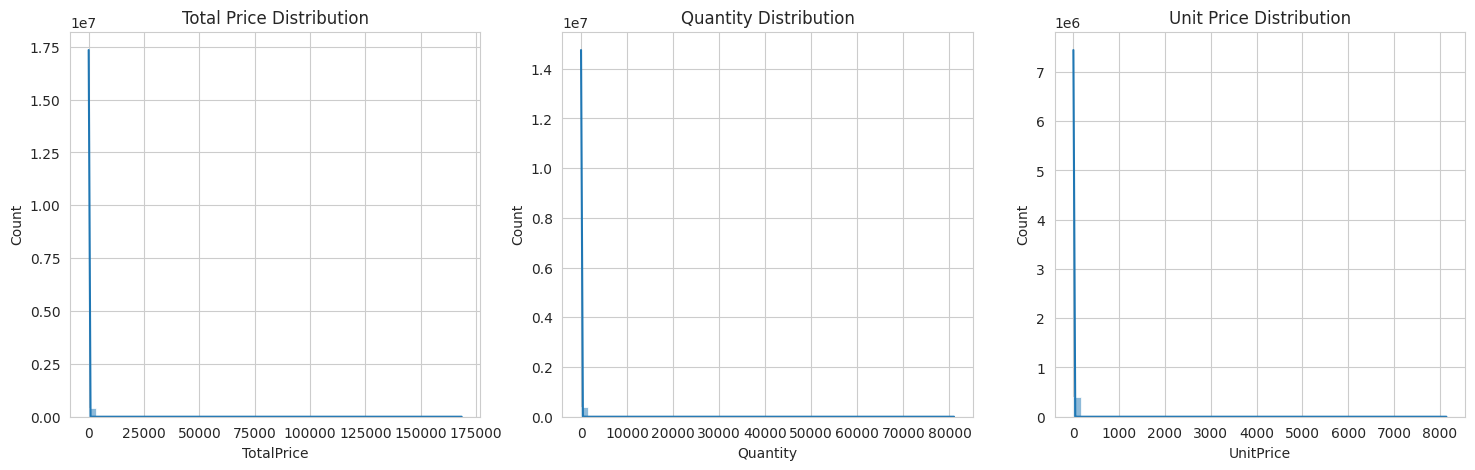

In [31]:
# Set style
sns.set_style("whitegrid")

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['TotalPrice'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Total Price Distribution")

sns.histplot(df['Quantity'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Quantity Distribution")

sns.histplot(df['UnitPrice'], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Unit Price Distribution")

plt.show()

# **Detect Outliers with IQR Method**
The **Interquartile Range (IQR)** helps detect extreme values by filtering out data points that fall outside the typical range.

In [32]:
# Define IQR limits
Q1 = df[['Quantity', 'UnitPrice', 'TotalPrice']].quantile(0.25)
Q3 = df[['Quantity', 'UnitPrice', 'TotalPrice']].quantile(0.75)
IQR = Q3 - Q1

# Set thresholds (1.5 * IQR rule)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_no_outliers = df[
    (df['Quantity'] >= lower_bound['Quantity']) & (df['Quantity'] <= upper_bound['Quantity']) &
    (df['UnitPrice'] >= lower_bound['UnitPrice']) & (df['UnitPrice'] <= upper_bound['UnitPrice']) &
    (df['TotalPrice'] >= lower_bound['TotalPrice']) & (df['TotalPrice'] <= upper_bound['TotalPrice'])
]

print(f"Original dataset size: {df.shape[0]}")
print(f"Dataset size after outlier removal: {df_no_outliers.shape[0]}")

Original dataset size: 392692
Dataset size after outlier removal: 323725


# **Re-visualize the data after removing outliers**

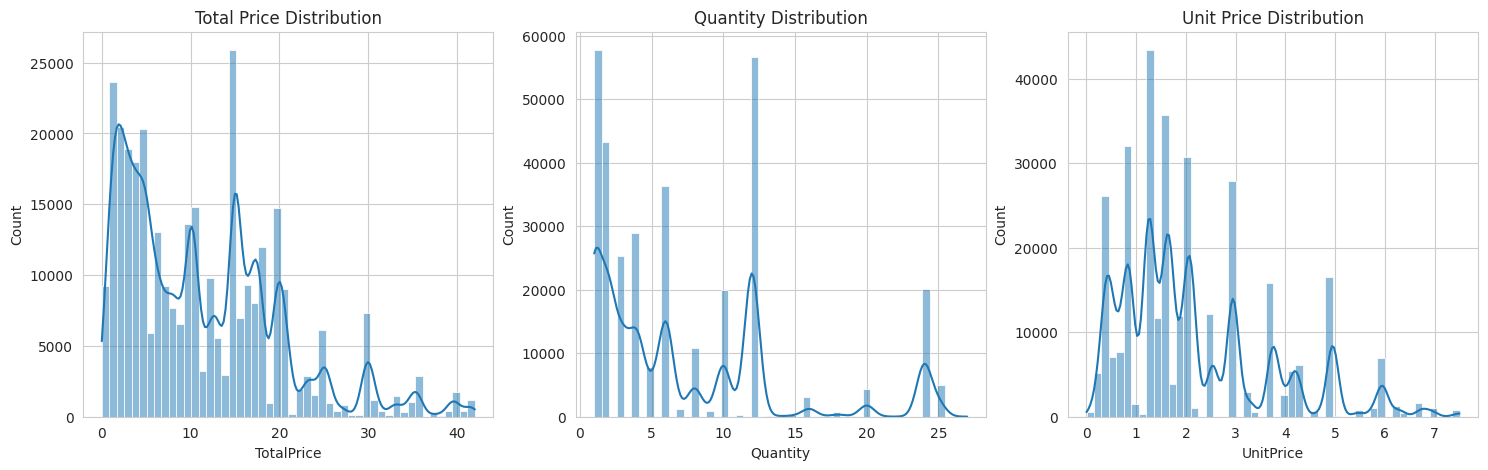

In [33]:
# Set style
sns.set_style("whitegrid")

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_no_outliers['TotalPrice'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Total Price Distribution")

sns.histplot(df_no_outliers['Quantity'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Quantity Distribution")

sns.histplot(df_no_outliers['UnitPrice'], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Unit Price Distribution")

plt.show()

# **Feature Engineering for Customer Segmentation**
Now that we’ve cleaned the data and removed outliers, let's create meaningful features to help with clustering.

## Create RFM Features (Recency, Frequency, Monetary Value)
**RFM Analysis** is a common customer segmentation technique:

- **Recency (R):** Days since last purchase
- **Frequency (F):** Number of purchases
- **Monetary (M):** Total spending

In [34]:
import datetime
# Create a copy to avoid modifying the original DataFrame
df_no_outliers = df_no_outliers.copy()

# Convert 'InvoiceDate' to datetime
df_no_outliers.loc[:, 'InvoiceDate'] = pd.to_datetime(df_no_outliers['InvoiceDate'])

# Set reference date (assume max date in data)
reference_date = df_no_outliers['InvoiceDate'].max()

# Compute RFM metrics
rfm = df_no_outliers.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary Value
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Display summary
print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12347.0           1        158   2901.57
12348.0         248          6     90.20
12349.0          18         57    939.75
12350.0         309         16    294.40
12352.0          35         66   1130.94


# **Visualizing RFM Features with Histograms**
This helps us see the spread of data and potential skewness.

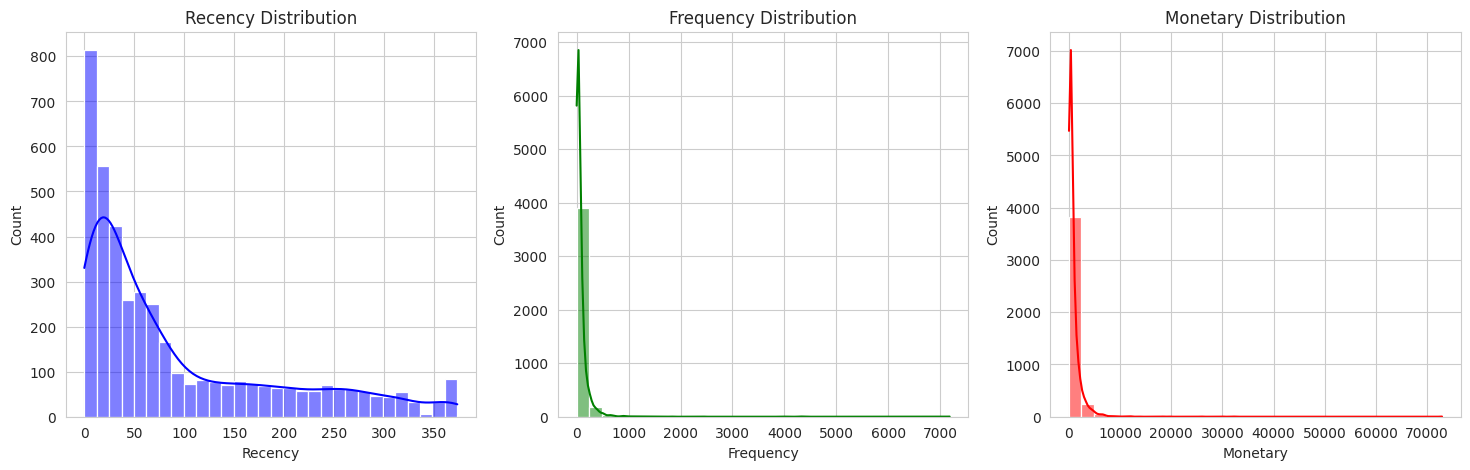

In [35]:
# Set figure size
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency Distribution
sns.histplot(rfm['Recency'], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Recency Distribution")

# Frequency Distribution
sns.histplot(rfm['Frequency'], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Frequency Distribution")

# Monetary Distribution
sns.histplot(rfm['Monetary'], bins=30, kde=True, ax=axes[2], color="red")
axes[2].set_title("Monetary Distribution")

plt.show()

# **Boxplots to Detect Outliers**
Boxplots help visualize outliers in each feature.

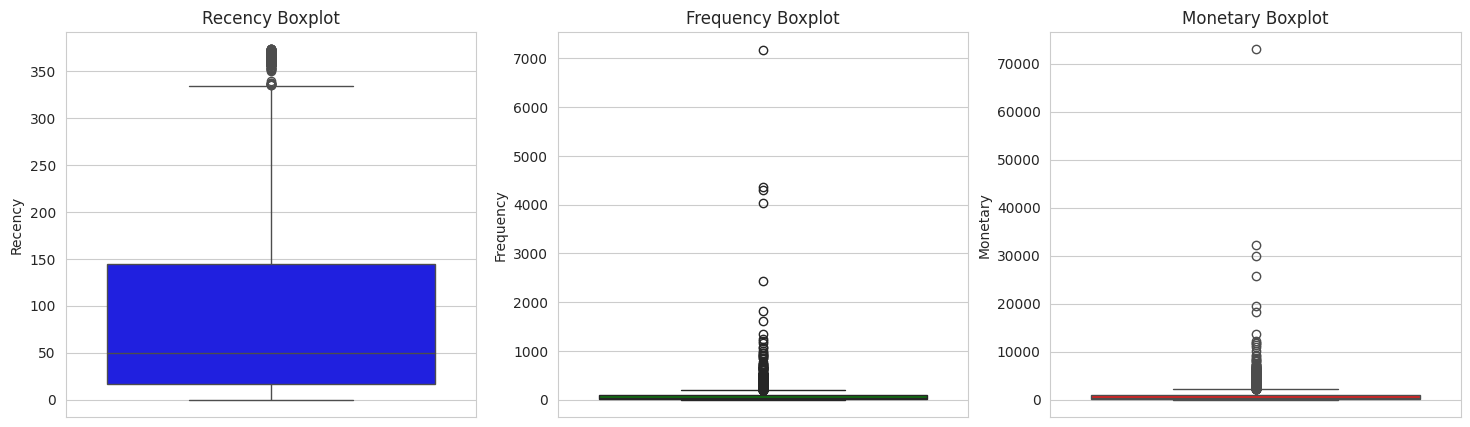

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency Boxplot
sns.boxplot(y=rfm['Recency'], ax=axes[0], color="blue")
axes[0].set_title("Recency Boxplot")

# Frequency Boxplot
sns.boxplot(y=rfm['Frequency'], ax=axes[1], color="green")
axes[1].set_title("Frequency Boxplot")

# Monetary Boxplot
sns.boxplot(y=rfm['Monetary'], ax=axes[2], color="red")
axes[2].set_title("Monetary Boxplot")

plt.show()

# **Applying Log Transformation to Reduce Skewness**
Since our **RFM distributions are heavily skewed**, a **log transformation** will help make them more normally distributed.

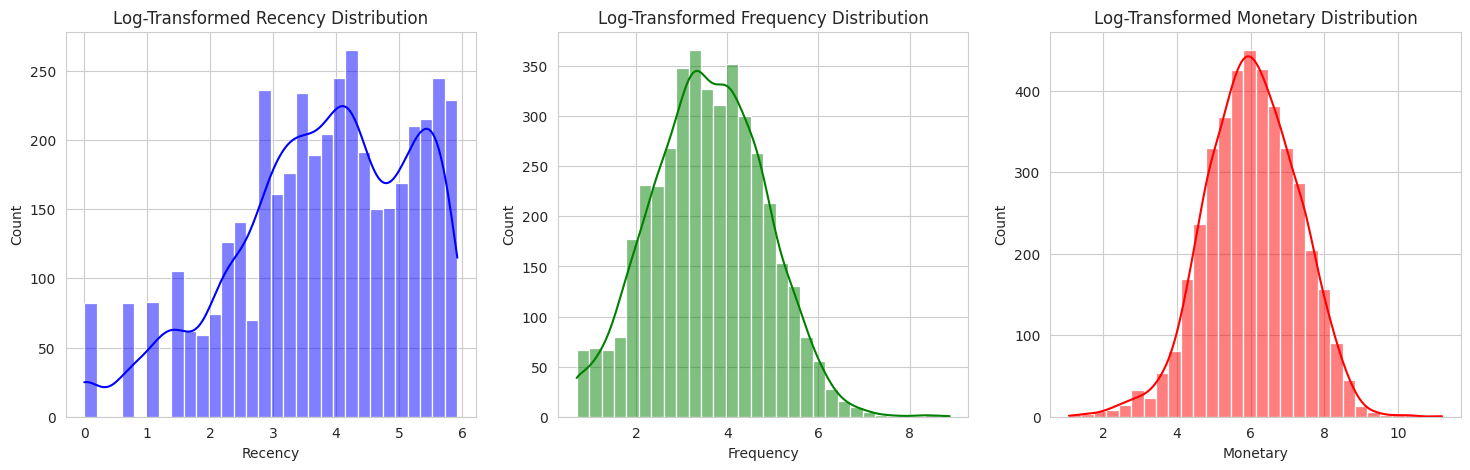

In [37]:
# Apply log transformation to Recency, Frequency, and Monetary
rfm_log = np.log1p(rfm)

# Visualize the transformed data
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency
sns.histplot(rfm_log['Recency'], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Log-Transformed Recency Distribution")

# Frequency
sns.histplot(rfm_log['Frequency'], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Log-Transformed Frequency Distribution")

# Monetary
sns.histplot(rfm_log['Monetary'], bins=30, kde=True, ax=axes[2], color="red")
axes[2].set_title("Log-Transformed Monetary Distribution")

plt.show()

# **Scale the Data (MinMax Scaling)**
After transformation, we scale the features to ensure all values are in a similar range (0 to 1).

In [38]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale the log-transformed RFM features
rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm_log), columns=rfm.columns, index=rfm.index)

# Display summary
print(rfm_scaled.head())

             Recency  Frequency  Monetary
CustomerID                               
12347.0     0.117002   0.534538  0.681819
12348.0     0.931333   0.153036  0.340320
12349.0     0.497014   0.411346  0.570627
12350.0     0.968319   0.261429  0.456309
12352.0     0.604889   0.428967  0.588886


# **Visualizing Log-Transformed RFM Distributions**
Now that we've applied the **log transformation**, let's see how the distributions look.



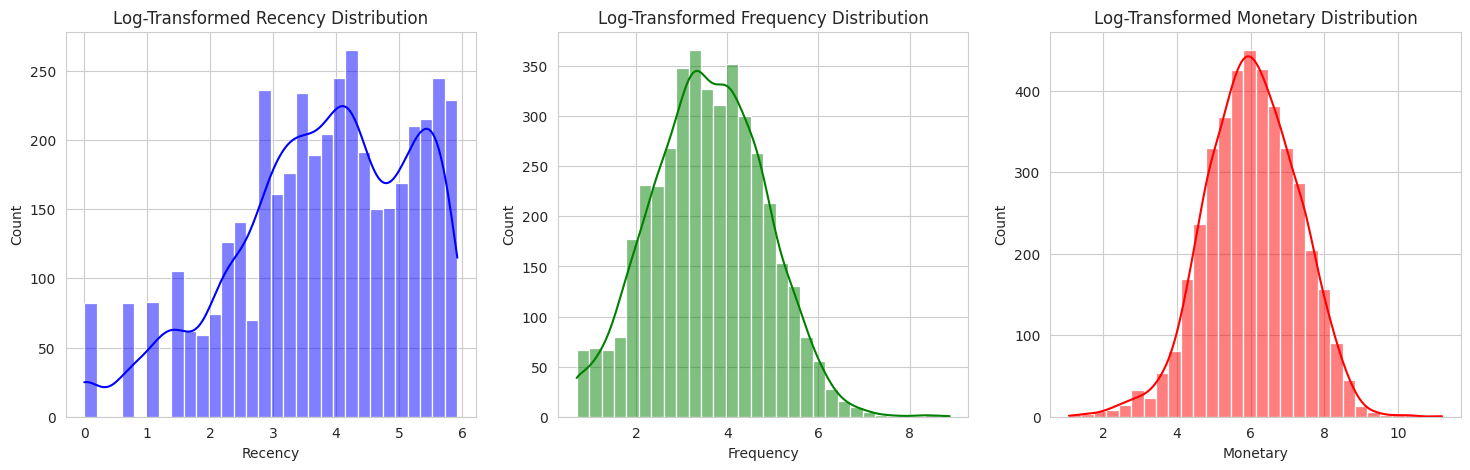

In [39]:
# Set figure size
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency Distribution
sns.histplot(rfm_log['Recency'], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Log-Transformed Recency Distribution")

# Frequency Distribution
sns.histplot(rfm_log['Frequency'], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Log-Transformed Frequency Distribution")

# Monetary Distribution
sns.histplot(rfm_log['Monetary'], bins=30, kde=True, ax=axes[2], color="red")
axes[2].set_title("Log-Transformed Monetary Distribution")

plt.show()

# **Plot Boxplots to Check Outliers After Transformation**

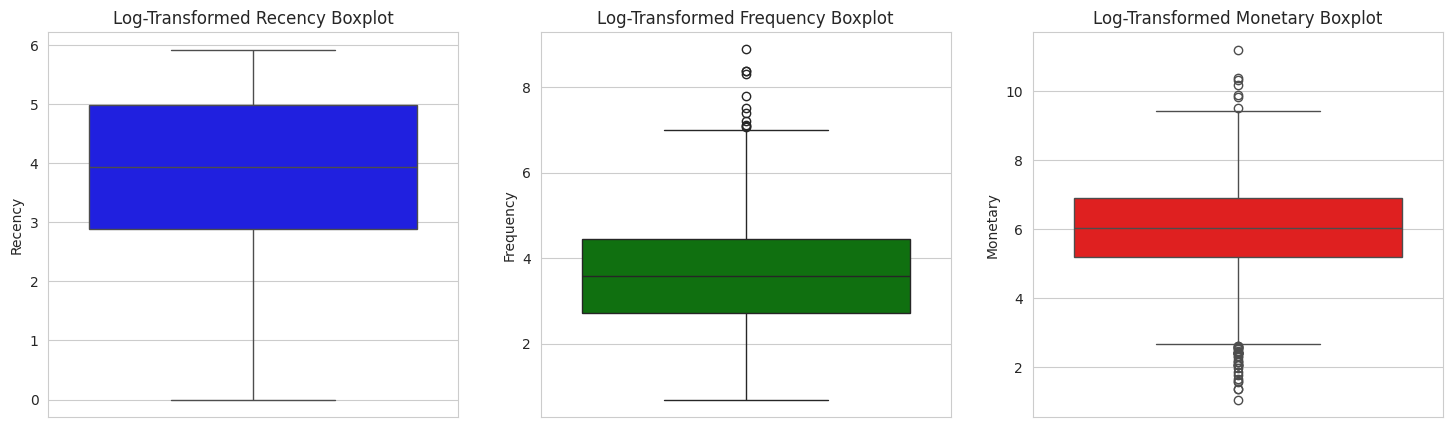

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency Boxplot
sns.boxplot(y=rfm_log['Recency'], ax=axes[0], color="blue")
axes[0].set_title("Log-Transformed Recency Boxplot")

# Frequency Boxplot
sns.boxplot(y=rfm_log['Frequency'], ax=axes[1], color="green")
axes[1].set_title("Log-Transformed Frequency Boxplot")

# Monetary Boxplot
sns.boxplot(y=rfm_log['Monetary'], ax=axes[2], color="red")
axes[2].set_title("Log-Transformed Monetary Boxplot")

plt.show()

# **K-Means Clustering on RFM Data**
We will:
1. Use the Elbow Method to determine the best number of clusters.
2. Fit K-Means to the log-transformed RFM data.
3. Visualize and analyze the clusters.

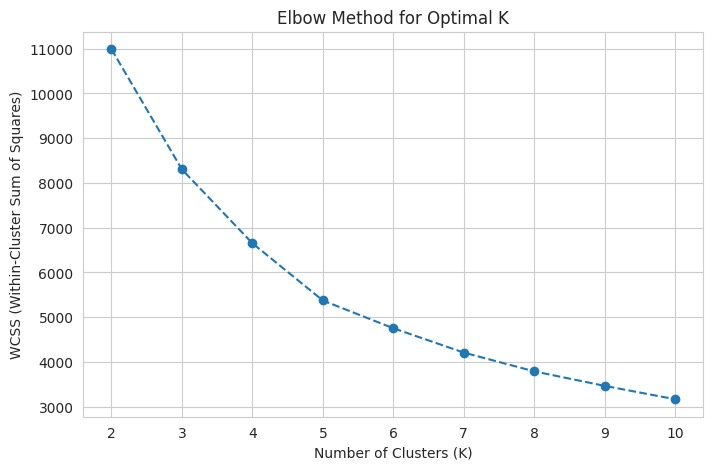

In [41]:
# Determine Optimal K (Elbow Method)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Define range for K (number of clusters)
wcss = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_log)  # Assuming "rfm_log" is your log-transformed RFM dataset
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

# **Apply K-Means with Optimal K**
Choose K based on the Elbow Method result.

In [42]:
optimal_k = 5 # Adjust based on the elbow method

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_log["Cluster"] = kmeans.fit_predict(rfm_log)

# View the first few rows
rfm_log.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12347.0,0.693147,5.068904,7.973352,1
12348.0,5.517453,1.945910,4.513055,0
12349.0,2.944439,4.060443,6.846677,4
12350.0,5.736572,2.833213,5.688330,2
12352.0,3.583519,4.204693,7.031688,4


# **Cluster Size Distribution**
This shows how customers are distributed across clusters.

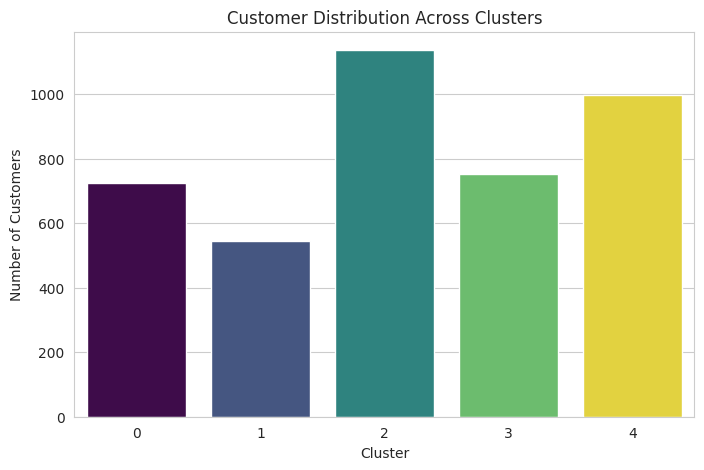

In [43]:
plt.figure(figsize=(8,5))
sns.countplot(x=rfm_log["Cluster"], hue=rfm_log["Cluster"], palette="viridis", legend=False)
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution Across Clusters")
plt.show()

# **RFM Distribution Per Cluster**
This helps analyze the characteristics of each cluster.

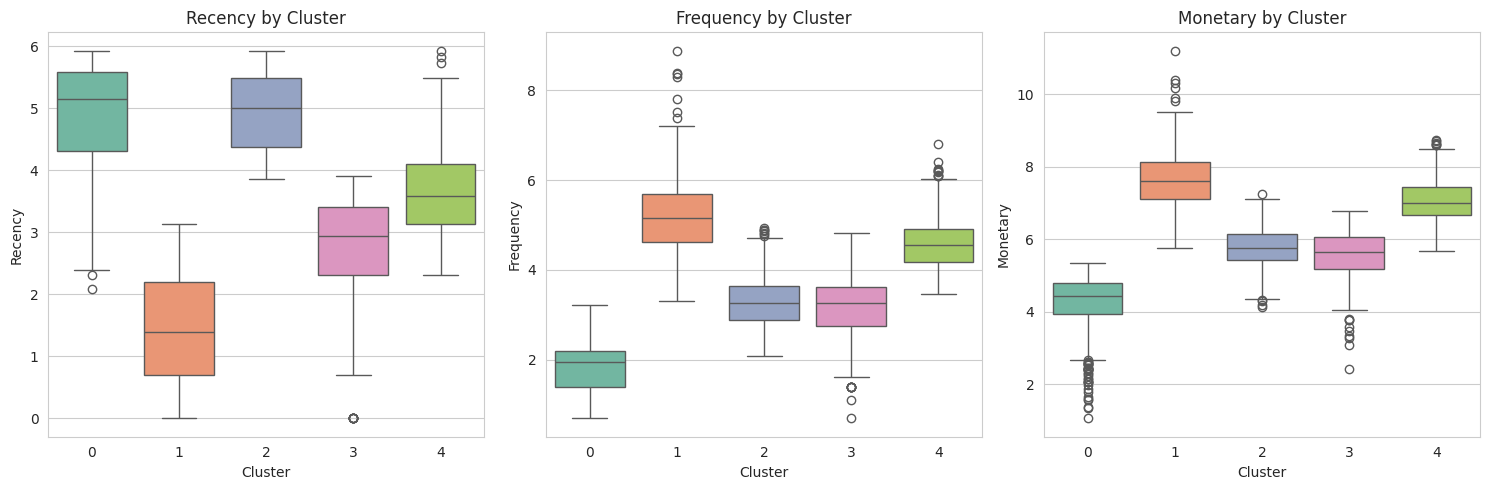

In [44]:
plt.figure(figsize=(15,5))

for i, col in enumerate(["Recency", "Frequency", "Monetary"]):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x="Cluster", y=col, data=rfm_log, hue = 'Cluster', legend = False, palette="Set2")
    plt.title(f"{col} by Cluster")

plt.tight_layout()
plt.show()

# **Analyze Clusters**
Calculate the average RFM values per cluster to understand the customer segments:

In [45]:
rfm_clusters = rfm_log.groupby("Cluster").mean()
print(rfm_clusters)

          Recency  Frequency  Monetary
Cluster                               
0        4.926216   1.820688  4.271761
1        1.481879   5.181408  7.633911
2        4.947940   3.295829  5.771484
3        2.761349   3.179904  5.604471
4        3.646563   4.594077  7.057186


# **Applying Hierarchical Clustering.**
To validate your K-Means clustering results, let's apply **Hierarchical Clustering** to compare their performance.

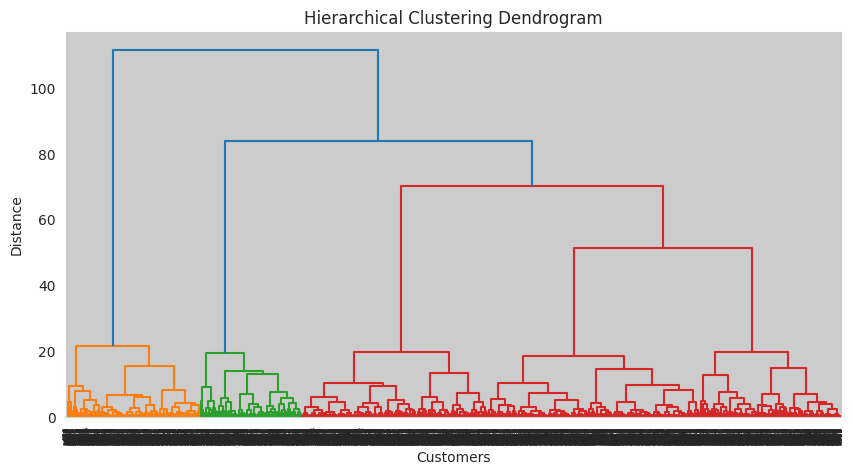

In [47]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


# Standardizing the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

### 1. Hierarchical Clustering
plt.figure(figsize=(10, 5))
linkage_matrix = linkage(rfm_scaled, method='ward')
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.show()

# **Visualizing Hierarchical Clustering Results**
Assign clusters and compare them with K-Means.


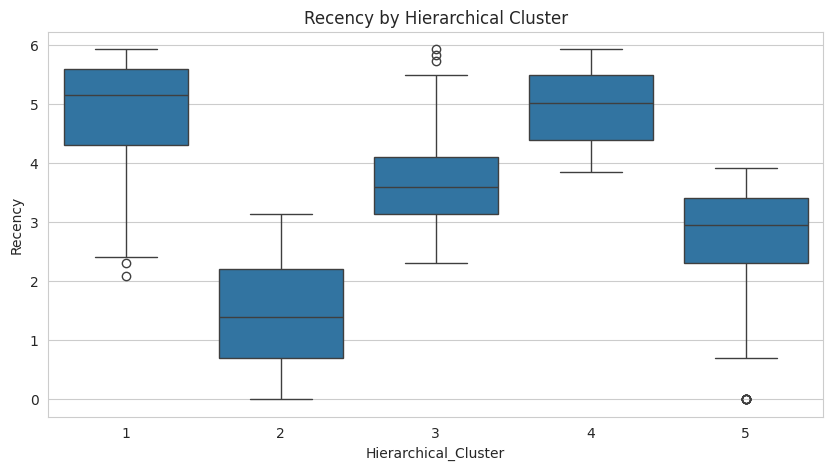

In [48]:
# Decide on number of clusters from dendrogram and apply Agglomerative Clustering
num_clusters = 5  # Change based on dendrogram observation
rfm_log['Hierarchical_Cluster'] = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Visualizing Hierarchical Clustering Results
plt.figure(figsize=(10, 5))
sns.boxplot(x=rfm_log['Hierarchical_Cluster'], y=rfm_log['Recency'])
plt.title("Recency by Hierarchical Cluster")
plt.show()

# **DBSCAN**
**DBSCAN** identifies density-based clusters and outliers.

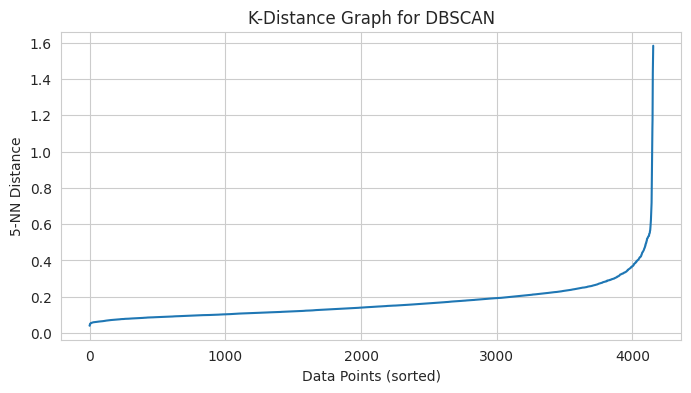

In [49]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# DBSCAN
# Determine optimal epsilon using k-distance plot
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(rfm_scaled)
distances, indices = nbrs.kneighbors(rfm_scaled)
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.xlabel("Data Points (sorted)")
plt.ylabel("5-NN Distance")
plt.title("K-Distance Graph for DBSCAN")
plt.show()

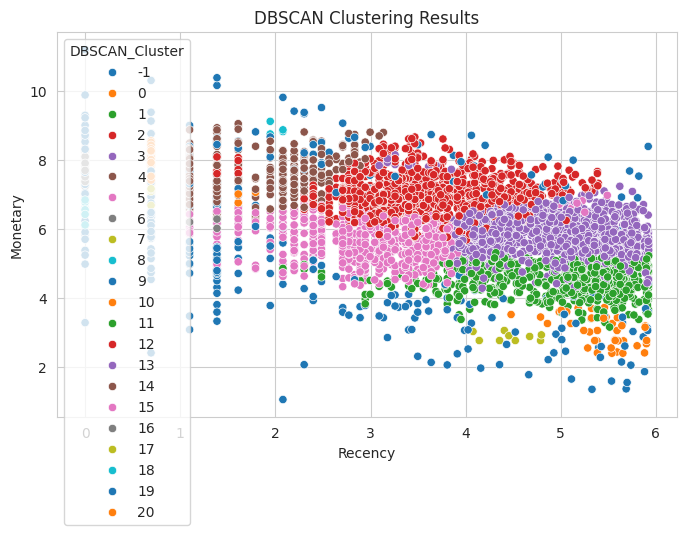

In [50]:
# Choose an epsilon value where the slope changes sharply
epsilon = 0.25 # Adjust based on the graph
min_samples = 5 # Typical default

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
rfm_log['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)

# Visualizing DBSCAN Clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x=rfm_log['Recency'], y=rfm_log['Monetary'], hue=rfm_log['DBSCAN_Cluster'], palette="tab10")
plt.title("DBSCAN Clustering Results")
plt.show()

In [51]:
# Count number of clusters and outliers
print(rfm_log['DBSCAN_Cluster'].value_counts())

# Outliers are labeled as -1 in DBSCAN
outliers = rfm_log[rfm_log['DBSCAN_Cluster'] == -1]
print(f"Number of Outliers Detected: {len(outliers)}")

DBSCAN_Cluster
 3     1126
 2      951
 5      662
 1      591
-1      302
 4      299
 10      38
 0       37
 6       34
 8       18
 14      13
 12      12
 13      10
 7        9
 15       9
 9        8
 17       8
 11       7
 16       6
 20       5
 19       5
 18       4
Name: count, dtype: int64
Number of Outliers Detected: 302
